In [1]:
import celmech as cm
import rebound as rb
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

In [2]:
from scipy.integrate import quad, trapz

from scipy.integrate import solve_ivp

In [3]:
def get_sim(m,Npl,pratio,exfrac):
    alpha = pratio**(-2/3)
    ex = np.min((1/alpha-1,1-alpha))
    sim = rb.Simulation()
    sim.add(m=1)
    P = 1
    for i in range(Npl):
        sim.add(m=m,P=P,l=np.random.uniform(-np.pi,np.pi),e=exfrac * ex,pomega= np.random.uniform(-np.pi,np.pi))
        P*= pratio
    sim.move_to_com()
    return sim

In [4]:
sim = get_sim(1e-5,5,1.15354,0.2)

pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
Hkep = pham.H.copy()

jlo,jhi = np.floor(1 + 1/(1.3456-1)),np.ceil(1 + 1/(1.3456-1))
jlo,jhi = int(jlo),int(jhi)

print(jlo,jhi)

for i in range(1,pvars.N-1):
    pham.add_MMR_terms(jlo,1,max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
    pham.add_MMR_terms(jhi,1,max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
    pham.add_MMR_terms(jhi+jhi,2,max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
    #pham.add_secular_terms(max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
    

3 4


/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/poincare.py:786: UserWarning: p and q share a common divisor. Some important terms may be omitted!
  warnings.warn("p and q share a common divisor. Some important terms may be omitted!")
/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/poincare.py:713: UserWarning: Cosine term k_vec=(8, -6, 0, -2, 0, 0), nu_vec=(0, 0, 0, 0), l_vec=(0, 0) already included Hamiltonian; no new term added.
  warnings.warn("Cosine term k_vec={0}, nu_vec={1}, l_vec={2} already included Hamiltonian; no new term added.".format(k_vec, nu_vec, l_vec))
/cita/h/home-2/hadden/Projects/01_celmech/celmech/celmech/poincare.py:713: UserWarning: Cosine term k_vec=(8, -6, -1, -1, 0, 0), nu_vec=(0, 0, 0, 0), l_vec=(0, 0) already included Hamiltonian; no new term added.
  warnings.warn("Cosine term k_vec={0}, nu_vec={1}, l_vec={2} already included Hamiltonian; no new term added.".format(k_vec, nu_vec, l_vec))
/cita/h/home-2/hadden/Projects/01_celmech/celmec

In [5]:
from celmech.canonical_transformations import reduce_hamiltonian

In [6]:
Hred = reduce_hamiltonian(pham)

Hred.H += -1 * Hkep

In [7]:
Npl = 5
jac=Hred.calculate_jacobian()
l_indx = [2*j for j in range(Npl)]
L_indx = [2*Npl + 2*j for j in range(Npl)]
evar_indx = [1 + 2*j for j in range(Npl)] + [2*Npl+ 1 + 2*j for j in range(Npl)]

Atilde = np.array([[jac[i,j] for j in evar_indx] for i in evar_indx])

evarsymbols = [Hred.qp_vars[j] for j in evar_indx]
L_symbols = [Hred.qp_vars[j] for j in L_indx]
l_symbols = [Hred.qp_vars[j] for j in l_indx]

ezero_rule={s:0 for s in evarsymbols}
btilde = np.array([Hred.N_flow[i].xreplace(ezero_rule).subs(Hred.qp) for i in evar_indx],dtype = float)


x0 = np.array([Hred.state.values[i] for i in evar_indx])
l0 = np.array([Hred.state.values[i] for i in l_indx])
L0 = np.array([Hred.state.values[i] for i in L_indx])

In [8]:
from celmech.miscellaneous import getOmegaMatrix
OmegaN = getOmegaMatrix(5)

In [9]:
Amtrx = sp.Matrix(2*Npl,2*Npl,lambda i,j: sp.diff(Hred.N_H,evarsymbols[i],evarsymbols[j]))
Afn = sp.lambdify(l_symbols,Amtrx)
bvec = sp.Matrix([sp.diff(Hred.N_H,evar).xreplace(ezero_rule) for evar in evarsymbols])
bfn = sp.lambdify(l_symbols,bvec)
grad_A = []
grad_b = sp.Matrix(Npl,2*Npl,lambda i,j: sp.diff(bvec[j],l_symbols[i]))
for l_symbol in l_symbols:
    grad_A.append(sp.diff(Amtrx,l_symbol))
grad_Afn = sp.lambdify(l_symbols,grad_A)
grad_bfn = sp.lambdify(l_symbols,grad_b)

In [10]:
GMmvec = pvars.G * pvars.G * np.array([p.M**2 * p.mu**3 for p in pvars.particles[1:]])

In [11]:
def H0soln(x0,l0,L0,h,GMmvec):
    Linv =1/L0
    Linv_cubed = Linv*Linv*Linv
    dl = h * Linv_cubed * GMmvec
    return x0,l0+dl,L0

In [12]:
(OmegaN @ Afn(*l0)) - (OmegaN @ Afn(*l0)).T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
def H1soln(x0,l0,L0,h,Afn,bfn,grad_Afn,grad_bfn,Omega,Npl):
    A = Afn(*l0)
    b = bfn(*l0)
    Atilde = Omega @ A
    btilde = Omega @ b
    assert np.alltrue(np.isclose(Atilde,Atilde.T))
    # diagonalize Atilde
    eigs,T = np.linalg.eigh(Atilde)
    D = np.diag(eigs)
    Dinv = np.diag(1/eigs)
    Atilde_inv = T @ Dinv @ T.T
    
    # forced eccentricity
    xf = -Atilde_inv @ btilde
    xf = xf.reshape(-1)
    
    # initial u
    u0 = T.T @ (x0 - xf)
    
    # final u
    uh = np.exp(eigs * h) * u0
    
    # x at time h
    xh = xf + T @ uh
    
    # integral of u from 0 to h
    Uh = (np.exp(h * eigs)  - 1)  * u0 / eigs
    # integral of u_i * u_j from 0 to h
    fn = lambda si,sj: h if np.isclose(si,-sj) else (np.exp((si + sj)*h) - 1) / (si + sj)
    UUh = np.outer(u0,u0)  * np.array([[fn(si,sj) for si in eigs] for sj in eigs])
    # integral of x from 0 to h
    Xh = xf * h + T @ Uh
    
    # integral of x_i * x_j from 0 to h
    XXh = h * np.outer(xf,xf)
    XXh += np.outer(xf,T @ Uh) + np.outer(T @ Uh, xf)
    XXh += T @ UUh @ T.T
    
    # Lambda solution
    dL = np.zeros(Npl)
    grad_A = grad_Afn(*l0)
    grad_b = grad_bfn(*l0)
    
    for i in range(Npl):
        dL[i] -= grad_b[i] @ Xh
        grad_Ai = grad_A[i]
        dL[i] -= 0.5 * np.sum([grad_Ai[j,k] * XXh[j,k] for j in range(2*Npl) for k in range(2*Npl)])
    return xh,l0,L0 + dL

In [14]:
Nout = 100
Tfin=250
state0  = np.array(Hred.state.values)
states = np.zeros((Nout,state0.shape[0]))
times = np.linspace(0,Tfin,Nout)

xsoln = np.zeros((Nout,x0.shape[0]))
Lsoln = np.zeros((Nout,L0.shape[0]))
lsoln = np.zeros((Nout,L0.shape[0]))
for i,t in enumerate(times):
    Hred.integrate(t)
    states[i] = Hred.state.values
    xsoln[i],lsoln[i],Lsoln[i] = H1soln(x0,l0,L0,t,Afn,bfn,grad_Afn,grad_bfn,getOmegaMatrix(5),5)
    

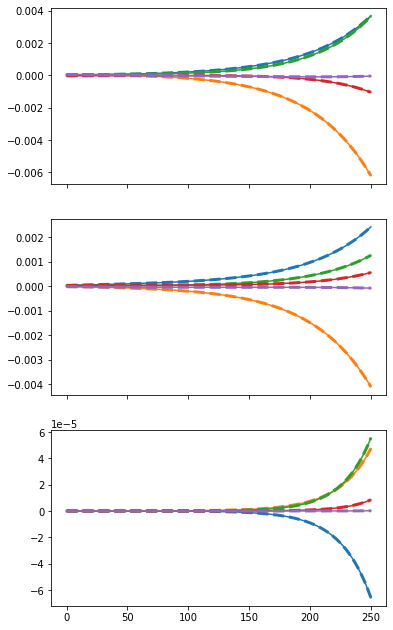

In [15]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(6,11))
plt.sca(ax[0])
for i in range(5):
    l,=plt.plot(times,states[:,1+2*i])
    plt.plot(times,xsoln[:,i],color=l.get_color(),ls='--',lw=3)


plt.sca(ax[1])
for i in range(5):
    l,=plt.plot(times,states[:,2*5+1+2*i])
    plt.plot(times,xsoln[:,5+i],color=l.get_color(),ls='--',lw=3)

# plt.plot(times,states[:,7])
# plt.plot(times,states[:,9])
# plt.plot(times,states[:,11])

plt.sca(ax[2])
for i in range(5):
    l,=plt.plot(times,states[:,2*5+2*i]-states[0,2*5+2*i])
    plt.plot(times,Lsoln[:,i]-Lsoln[0,i],ls='--',lw=3,color=l.get_color())

In [16]:
to_state = lambda x,l,L: np.array([(l[i],x[i],0) for i in range(5)] + [(L[i],x[5+i],0) for i in range(5)]).reshape(-1)

In [17]:
h = 1
Niter = 10_000#_000

xsoln = np.zeros((Niter,x0.shape[0]))
Lsoln = np.zeros((Niter,L0.shape[0]))
lsoln = np.zeros((Niter,l0.shape[0]))
Energy = np.zeros(Niter)

states = np.zeros((Niter,pham.N_dim))
x,l,L = x0.copy(),l0.copy(),L0.copy()


for i in range(Niter):
    xsoln[i],lsoln[i],Lsoln[i] = x,l,L
    Energy[i] = pham.H_func(*to_state(x,l,L))
    x,l,L = H0soln(x,l,L,0.5*h,GMmvec)
    x,l,L = H1soln(x,l,L,h,Afn,bfn,grad_Afn,grad_bfn,getOmegaMatrix(5),5)
    x,l,L = H0soln(x,l,L,0.5*h,GMmvec)
        

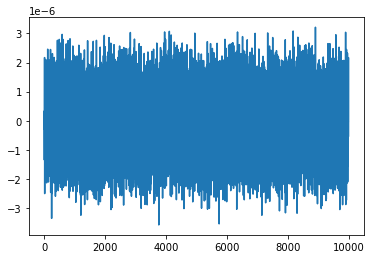

In [18]:
Eav = np.mean(Energy)
plt.plot(h*np.arange(Niter),Energy/Eav - 1)

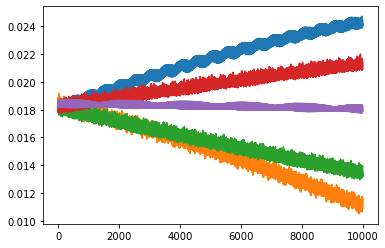

In [19]:

for i in range(5):
    ecc = np.sqrt((xsoln[:,i]**2 + xsoln[:,i+5]**2)/Lsoln[:,i])
    plt.plot(np.arange(Niter) * h, ecc )


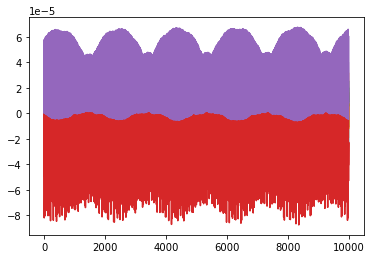

In [20]:
for i in range(5):
    plt.plot(np.arange(Niter) * h, (Lsoln[:,i] - Lsoln[0,i]) / Lsoln[0,i])
#     ipham = pham.qp_vars.index(L_symbols[i])
#     plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')

In [21]:
# %%time
# for i in range(Niter):
#     pham.integrate(i*h)
#     states[i] = pham.state.values
    
    

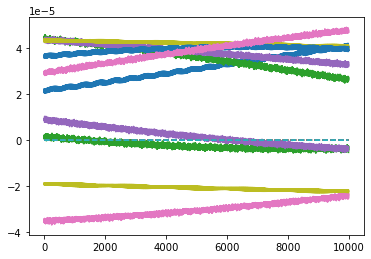

In [22]:
for i in range(10):
    plt.plot(np.arange(Niter) * h, xsoln[:,i])
    ipham = pham.qp_vars.index(evarsymbols[i])
    plt.plot(np.arange(Niter) * h, states[:,ipham],ls='--')

/tmp/ipykernel_3681141/1143706005.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')
/tmp/ipykernel_3681141/1143706005.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')
/tmp/ipykernel_3681141/1143706005.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')
/tmp/ipykernel_3681141/1143706005.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')
/tmp/ipykernel_3681141/1143706005.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')


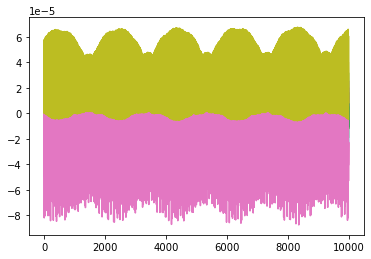

In [23]:
for i in range(5):
    plt.plot(np.arange(Niter) * h, (Lsoln[:,i] - Lsoln[0,i]) / Lsoln[0,i])
    ipham = pham.qp_vars.index(L_symbols[i])
    plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--')